In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
%pip install pandas-summary

# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')
o_df_product_category_name_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

# 카피본 생성
df_customers = o_df_customers.copy()
df_geolocation = o_df_geolocation.copy()
df_order_items = o_df_order_items.copy()
df_order_payments = o_df_order_payments.copy()
df_order_reviews = o_df_order_reviews.copy()
df_products = o_df_products.copy()
df_sellers = o_df_sellers.copy()
df_product_category_name_translation = o_df_product_category_name_translation.copy()


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


In [1]:
# 8개 데이터프레임의 결측값 분석
def check_missing(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"\n📊 {name} 데이터프레임 결측값 분석")
        
        missing_info = df.isnull().sum()
        m_pct = (missing_info / len(df)) * 100
        
        if missing_info.sum() == 0:
            print("✅ 결측값 없음. 완전")
        else:
            print("⚠️ 결측치 존재")
            missing_sum = pd.DataFrame({
                '결측수': missing_info,
                '결측율(%)': m_pct,
            }).round(2)
            missing_sum = missing_sum[missing_sum['결측수'] > 0]
            display(missing_sum)

# 사용 예시
original_dfs = [ 
    o_df_customers, o_df_geolocation, o_df_order_items,
    o_df_order_payments, o_df_order_reviews, o_df_products,
    o_df_sellers, o_df_product_category_name_translation,
]

df_names = [
    "customers", "geolocation", "order_items",
    "order_payments", "order_reviews", "products",
    "sellers", "product_category_name_translation",
]

check_missing(original_dfs, df_names)

NameError: name 'o_df_customers' is not defined

# 전처리

In [4]:
# df_products

# 결측치
# 텍스트 리뷰 활용: 제목/메시지는 결측을 그대로 두고 "No Comment" 처리
# 이상치


전체 데이터 행 수: 112,650
IsolationForest 모델이 탐지한 이상치 개수: 1,127
이상치 비율: 1.00%


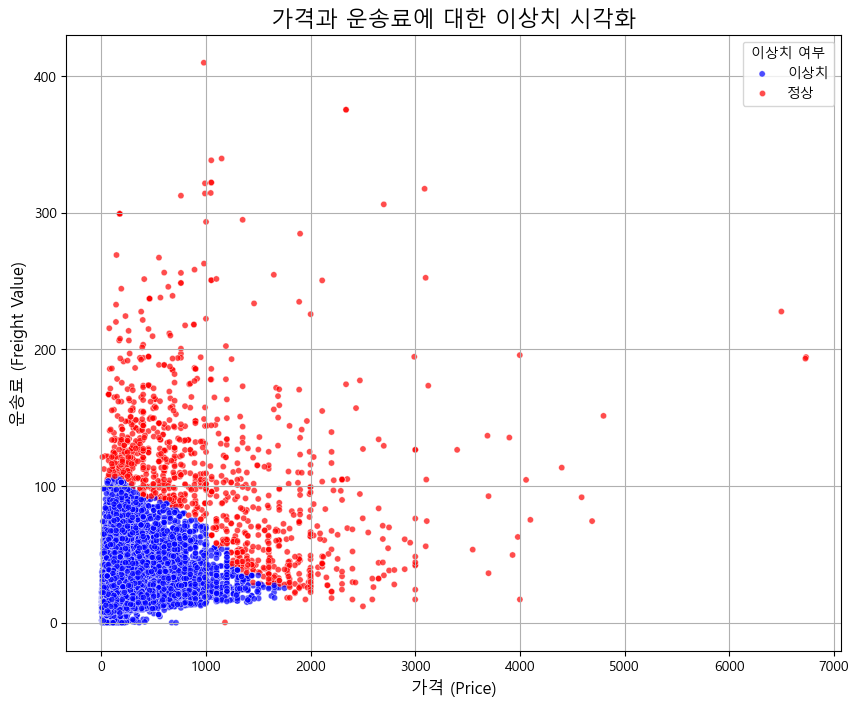

=== 'price' 컬럼 이상치 처리 후 통계량 ===
count    112650.000000
mean        115.296942
std         136.362223
min           9.990000
25%          39.900000
50%          74.990000
75%         134.900000
max         890.000000
Name: price, dtype: float64

=== 'freight_value' 컬럼 이상치 처리 후 통계량 ===
count    112650.000000
mean         19.638178
std          12.816924
min           4.419800
25%          13.080000
50%          16.260000
75%          21.150000
max          84.520000
Name: freight_value, dtype: float64


In [5]:
# df_order_items 이상치 탐지
from sklearn.ensemble import IsolationForest

# 모델 초기화 (contamination은 이상치 비율을 가정)
model = IsolationForest(contamination=0.01) # 1%의 이상치가 있다고 가정

# 모델 학습 및 이상치 예측 (-1은 이상치, 1은 정상 데이터)
df_order_items['outlier_flag'] = model.fit_predict(df_order_items[['price', 'freight_value']])

# 이상치 개수 계산
outlier_count = df_order_items[df_order_items['outlier_flag'] == -1].shape[0]

# f-string을 사용해 결과 출력
print(f"전체 데이터 행 수: {len(df_order_items):,}")
print(f"IsolationForest 모델이 탐지한 이상치 개수: {outlier_count:,}")
print(f"이상치 비율: {(outlier_count / len(df_order_items)):.2%}")

# 이상치 시각화: 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='price', 
    y='freight_value', 
    data=df_order_items, 
    hue='outlier_flag', 
    palette=['red', 'blue'], 
    s=20,
    alpha=0.7
)

plt.title('가격과 운송료에 대한 이상치 시각화', fontsize=16)
plt.xlabel('가격 (Price)', fontsize=12)
plt.ylabel('운송료 (Freight Value)', fontsize=12)
plt.legend(title='이상치 여부', labels=['이상치', '정상'])
plt.grid(True)
plt.show()

# 실제 비즈니스적 맥락에서의 해석:
# 가격과 운송료가 모두 극단적으로 낮은 상품은 샘플, 이벤트용 상품, 또는 데이터 입력 오류일 가능성이 있습니다.
# 이상치는 값 대체해서 처리

# 이상치 대체 함수
def winsorize_outliers(df, column_name):
    """
    1%와 99% 백분위수 값을 기준으로 이상치를 대체합니다.
    """
    lower_bound = df[column_name].quantile(0.01)
    upper_bound = df[column_name].quantile(0.99)
    
    # 1%보다 작은 값을 1% 값으로, 99%보다 큰 값을 99% 값으로 대체
    df[column_name] = np.where(df[column_name] < lower_bound, lower_bound, df[column_name])
    df[column_name] = np.where(df[column_name] > upper_bound, upper_bound, df[column_name])
    return df

# 'price'와 'freight_value' 컬럼의 이상치 대체
df_order_items = winsorize_outliers(df_order_items.copy(), 'price')
df_order_items = winsorize_outliers(df_order_items.copy(), 'freight_value')

# 이상치 처리 후의 데이터 통계량 확인
print("=== 'price' 컬럼 이상치 처리 후 통계량 ===")
print(df_order_items['price'].describe())
print("\n=== 'freight_value' 컬럼 이상치 처리 후 통계량 ===")
print(df_order_items['freight_value'].describe())


In [6]:
'''
df_review 

1. 데이터 상황 요약
review_comment_title: 결측치 88% → 고객 대부분이 제목은 아예 작성하지 않음.
review_comment_message: 결측치 59% → 절반 이상이 코멘트를 남기지 않음.
review_score (별점): 결측치 없음 (모든 리뷰는 점수 필수).
'''

# --- 리뷰 메시지 작성 여부 플래그 생성 ---
df_order_reviews["has_comment"] = df_order_reviews["review_comment_message"].notnull().astype(int)

# --- 리뷰 제목/메시지 결측치 "No Comment"로 치환 ---
df_order_reviews["review_comment_title"] = df_order_reviews["review_comment_title"].fillna("No Comment")
df_order_reviews["review_comment_message"] = df_order_reviews["review_comment_message"].fillna("No Comment")

# 확인
print(df_order_reviews[["review_score", "has_comment", "review_comment_title", "review_comment_message"]].head())
print("\n📌 has_comment 분포")
print(df_order_reviews["has_comment"].value_counts(normalize=True).round(3) * 100)


   review_score  has_comment review_comment_title  \
0             4            0           No Comment   
1             5            0           No Comment   
2             5            0           No Comment   
3             5            1           No Comment   
4             5            1           No Comment   

                              review_comment_message  
0                                         No Comment  
1                                         No Comment  
2                                         No Comment  
3              Recebi bem antes do prazo estipulado.  
4  ParabÃ©ns lojas lannister adorei comprar pela ...  

📌 has_comment 분포
has_comment
0    58.7
1    41.3
Name: proportion, dtype: float64


In [7]:
# orders 파일 읽어오기
file_path_absolute ='C:/Users/mumu1/Desktop/project_movie_data/project_dataset/olist_orders_dataset.csv'
o_df_order = pd.read_csv(file_path_absolute, encoding='ISO-8859-1')

df_order = o_df_order.copy()

# orders 데이터 탐색 : 누락, 중복, 이상 확인, 결측치 확인
display(o_df_order.head())
o_df_order.describe()
o_df_order.info()
o_df_order.isnull().sum()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [8]:
# df_order 결측치 처리

# 1. 결측치를 확인할 컬럼 리스트 정의
missing_value_cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']

# 2. 각 컬럼별로 결측치 여부를 확인하는 불리언 마스크(Boolean Mask) 생성
# 'isnull()' 함수는 결측치(NaN)일 때 True를 반환합니다.
approved_at_na = df_order['order_approved_at'].isnull()
carrier_date_na = df_order['order_delivered_carrier_date'].isnull()
customer_date_na = df_order['order_delivered_customer_date'].isnull()

# 3. 세 가지 마스크를 '|' (or) 연산자로 결합
# 이 조건들 중 하나라도 True인 행을 선택합니다.
na_mask = approved_at_na | carrier_date_na | customer_date_na

# 4. 마스크를 사용하여 결측값이 있는 행만 필터링
df_na = df_order[na_mask]

# 5. 필터링된 데이터의 일부를 확인
print("결측값이 있는 행의 데이터 샘플:")
print(df_na.head())

# 6. 결측값이 있는 행의 개수 확인
print(f"\n결측값이 있는 총 행의 수: {len(df_na)}")

# o_df_order 결측률
print(df_order.isnull().sum() / len(df_order))

# 5%이하 3개 컬럼의 결측치 제거
df_order.dropna(subset=['order_approved_at'], inplace=True)
df_order.dropna(subset=['order_delivered_carrier_date'], inplace=True)
df_order.dropna(subset=['order_delivered_customer_date'], inplace=True)

# 변경사항 확인
print("결측치 제거 후 df_order의 정보:")
print(df_order.info())


결측값이 있는 행의 데이터 샘플:
                             order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44   ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103  0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128  15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154  6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   

    order_status order_purchase_timestamp    order_approved_at  \
6       invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
44       shipped      2018-06-04 16:44:48  2018-06-05 04:31:18   
103     invoiced      2018-08-03 17:44:42  2018-08-07 06:15:14   
128   processing      2017-09-03 14:22:03  2017-09-03 14:30:09   
154      shipped      2018-01-10 11:33:07  2018-01-11 02:32:30   

    order_delivered_carrier_date order_delivered_customer_date  \
6                            NaN                           NaN   
4

In [9]:
# 이상치 탐지: 계산한 배송시간 차이가 크거나 작은 경우
print('\n=== 이상값 확인 ===')

# 데이터 타입 변환
df_order["order_approved_at"] = pd.to_datetime(df_order["order_approved_at"])
df_order["order_purchase_timestamp"] = pd.to_datetime(df_order["order_purchase_timestamp"])
df_order["order_delivered_carrier_date"] = pd.to_datetime(df_order["order_delivered_carrier_date"])
df_order["order_delivered_customer_date"] = pd.to_datetime(df_order["order_delivered_customer_date"])
df_order["order_purchase_timestamp"] = pd.to_datetime(df_order["order_purchase_timestamp"])
df_order["order_estimated_delivery_date"] = pd.to_datetime(df_order["order_estimated_delivery_date"])

# 시간 차이 계산 (일 단위)
# 결제까지 걸린 시간: 주문승인일 - 결제일
df_order["purchase_to_approved"] = (df_order["order_approved_at"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400
# 주문-배송 걸린 시간: 배송완료일 - 주문승인일
df_order["approved_to_carrier"] = (df_order["order_delivered_carrier_date"] - df_order["order_approved_at"]).dt.total_seconds()/86400
# 택배사-배송 걸린 시간: 배송완료일 - 택배사 전달일
df_order["carrier_to_customer"] = (df_order["order_delivered_customer_date"] - df_order["order_delivered_carrier_date"]).dt.total_seconds()/86400
# 계산-배송 걸린 시간: - 배송완료일 - 주문계산일
df_order["purchase_to_customer"] = (df_order["order_delivered_customer_date"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400

# 모든 시간 계산 컬럼에서 음수 값만 찾기
# 시간 계산 컬럼 리스트
time_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]

# 각 컬럼별 음수 개수 계산
neg_counts = {col: (df_order[col] < 0).sum() for col in time_cols}

# 전체 음수 개수 (한 행이라도 음수인 경우)
total_neg = df_order[(df_order[time_cols] < 0).any(axis=1)].shape[0]

# 결과 출력
print("컬럼별 음수 개수:", neg_counts)
print("전체 음수 개수 (한 행이라도 음수):", total_neg)


=== 이상값 확인 ===
컬럼별 음수 개수: {'purchase_to_approved': np.int64(0), 'approved_to_carrier': np.int64(1350), 'carrier_to_customer': np.int64(23), 'purchase_to_customer': np.int64(0)}
전체 음수 개수 (한 행이라도 음수): 1373


1) 데이터 무결성 & 계산값 검증

이미 계산해둔 4개 지표가 맞는지 **허용 오차(±1초=1/86400일)**로 교차검증합니다.
또한 음수/이상치, delivered 이외 상태 존재 여부를 점검합니다.

In [10]:
# 1-1. datetime dtype 보장
datetime_cols = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for c in datetime_cols:
    assert pd.api.types.is_datetime64_any_dtype(df_order[c]), f"{c}는 datetime 타입이어야 합니다."

# 1-2. 로직 재계산(검증용 임시 컬럼)
EPS = 1/86400  # 1초
calc = pd.DataFrame(index=df_order.index)
calc["purchase_to_approved_chk"] = (df_order["order_approved_at"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400
calc["approved_to_carrier_chk"]  = (df_order["order_delivered_carrier_date"] - df_order["order_approved_at"]).dt.total_seconds()/86400
calc["carrier_to_customer_chk"]  = (df_order["order_delivered_customer_date"] - df_order["order_delivered_carrier_date"]).dt.total_seconds()/86400
calc["purchase_to_customer_chk"] = (df_order["order_delivered_customer_date"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400

# 1-3. 기존 값과 일치 여부 확인
diffs = {
    "purchase_to_approved": (df_order["purchase_to_approved"] - calc["purchase_to_approved_chk"]).abs().max(),
    "approved_to_carrier": (df_order["approved_to_carrier"] - calc["approved_to_carrier_chk"]).abs().max(),
    "carrier_to_customer": (df_order["carrier_to_customer"] - calc["carrier_to_customer_chk"]).abs().max(),
    "purchase_to_customer": (df_order["purchase_to_customer"] - calc["purchase_to_customer_chk"]).abs().max(),
}
print("[검증] 최대 절대 오차(일):", diffs)
for k,v in diffs.items():
    assert v <= EPS, f"{k} 계산값이 사전 계산과 불일치 (max abs diff={v}일)"

# 1-4. 상태값 점검
status_counts = df_order["order_status"].value_counts(dropna=False)
print("\n[상태 분포]\n", status_counts)

# 1-5. delivered 필터 (상황에 따라 전체 vs delivered 별도 분석 가능)
df_deliv = df_order[df_order["order_status"]=="delivered"].copy()
print(f"\n[delivered 개수] {len(df_deliv):,} / 전체 {len(df_order):,}")

# 1-6. 음수/이상치 점검 (시간은 음수가 아니어야 정상)
duration_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]
neg_mask = (df_deliv[duration_cols] < -EPS).any(axis=1)
if neg_mask.any():
    print("\n[경고] 음수 시간 발견 (샘플 5개):\n", df_deliv.loc[neg_mask, ["order_id"]+duration_cols].head())
    # 필요 시 제외
    # df_deliv = df_deliv.loc[~neg_mask].copy()

# 1-7. 비현실적 장기 값(상위 0.5% 이상치) 확인
hi_thresh = df_deliv["purchase_to_customer"].quantile(0.995)
print(f"\n[알림] purchase_to_customer 상위 0.5% 컷오프: {hi_thresh:.2f}일 (참고용)")

# 'purchase_to_customer' 값이 26.73일보다 큰 이상치 데이터 필터링 후 제거
df_deliv_cleaned = df_deliv[df_deliv['purchase_to_customer'] <= 26.73]

# 이상치 제거 후 데이터 크기 확인
print(f"이상치 제거 전 행 수: {len(df_deliv):,}")
print(f"이상치 제거 후 행 수: {len(df_deliv_cleaned):,}")


[검증] 최대 절대 오차(일): {'purchase_to_approved': np.float64(0.0), 'approved_to_carrier': np.float64(0.0), 'carrier_to_customer': np.float64(0.0), 'purchase_to_customer': np.float64(0.0)}

[상태 분포]
 order_status
delivered    96455
canceled         6
Name: count, dtype: int64

[delivered 개수] 96,455 / 전체 96,461

[경고] 음수 시간 발견 (샘플 5개):
                              order_id  purchase_to_approved  \
15   dcb36b511fcac050b97cd5c05de84dc3              5.185995   
64   688052146432ef8253587b930b01a06d              2.400799   
199  58d4c4747ee059eeeb865b349b41f53a              5.446076   
210  412fccb2b44a99b36714bca3fef8ad7b              0.584583   
415  56a4ac10a4a8f2ba7693523bb439eede              5.434977   

     approved_to_carrier  carrier_to_customer  purchase_to_customer  
15             -1.359051            10.028148             13.855093  
64             -0.962593             1.008843              2.447049  
199            -2.440891             1.459248              4.464433  
210          

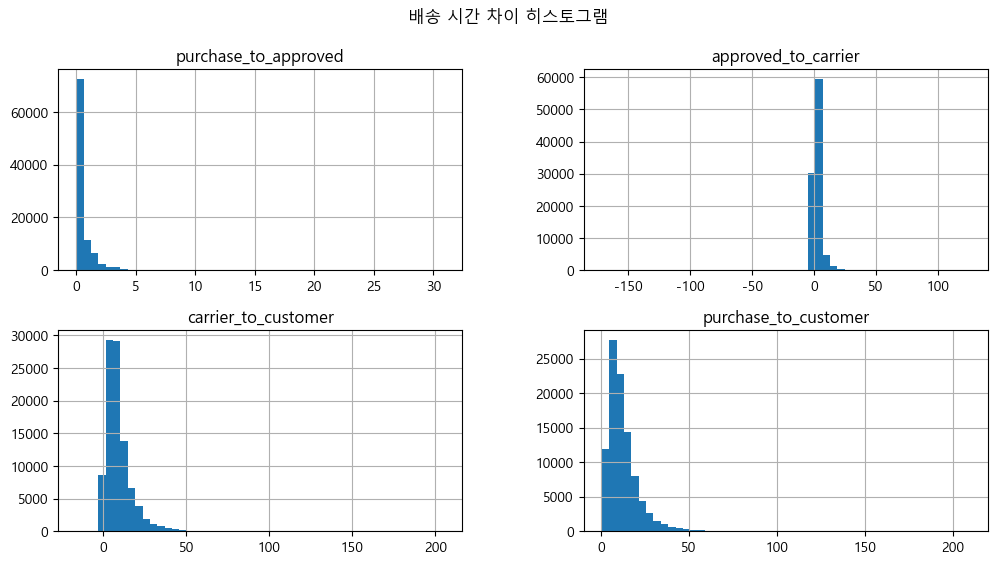

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.26%
approved_to_carrier: 5.80%
carrier_to_customer: 5.26%
purchase_to_customer: 5.08%


In [11]:
# df_order 이상치 탐지 시각화

# 1️⃣ 히스토그램 시각화
df_order[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("배송 시간 차이 히스토그램")
plt.show()

# 2️⃣ 극단치 비율 계산
print("=== Z-score 기준 이상치 비율 (|Z|>3) ===")
for col in time_cols:
    z = zscore(df_order[col].dropna())
    outlier_ratio = (abs(z) > 3).mean() * 100
    print(f"{col}: {outlier_ratio:.2f}%")

# 3️⃣ IQR 기반 이상치 비율 계산
print("\n=== IQR 기준 이상치 비율 ===")
for col in time_cols:
    data = df_order[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    iqr_outlier_ratio = ((data < lower_bound) | (data > upper_bound)).mean() * 100
    print(f"{col}: {iqr_outlier_ratio:.2f}%")

In [12]:
# --- 이상치 플래그 추가 ---
df_order["is_outlier"] = (df_order[time_cols] < 0).any(axis=1)

# 이상치 개수 확인
print("이상치 건수:", df_order["is_outlier"].sum())

# 이상치 제외한 데이터프레임 생성
df_order_clean = df_order[~df_order["is_outlier"]].copy()

print("정제 후 데이터 크기:", df_order_clean.shape)


이상치 건수: 1373
정제 후 데이터 크기: (95088, 13)


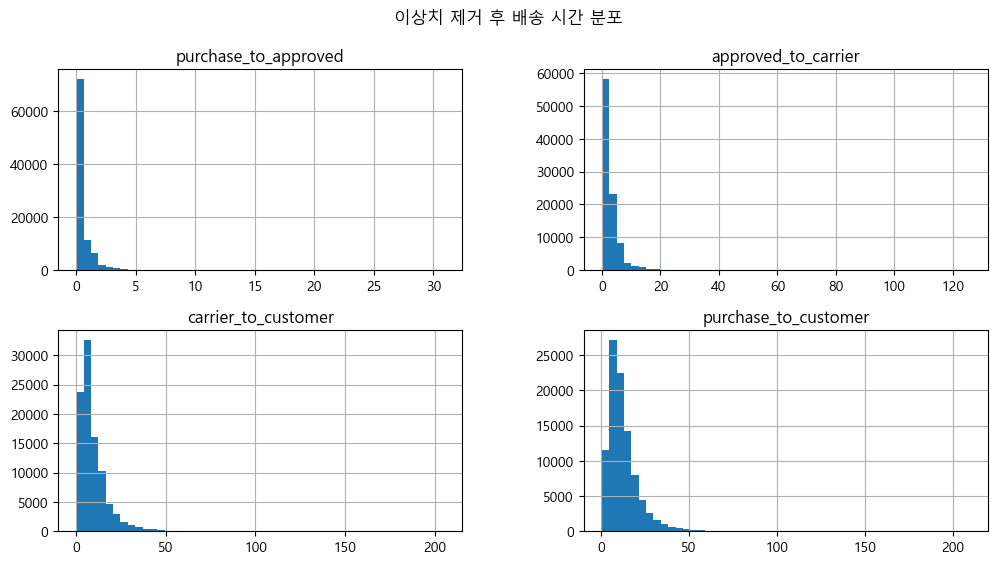

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_to_approved,approved_to_carrier,carrier_to_customer,purchase_to_customer
count,95088,95088,95088,95088,95088,95088.000000,95088.000000,95088.000000,95088.000000
mean,2017-12-31 02:58:13.884559616,2017-12-31 12:37:15.921357056,2018-01-03 09:04:07.208028416,2018-01-12 17:48:48.140701184,2018-01-23 20:52:29.318526208,0.402107,2.851982,9.364363,12.618452
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,0.000000,0.000174,0.000000,0.533414
25%,2017-09-12 21:57:03,2017-09-13 11:25:10.500000,2017-09-15 15:44:43.750000128,2017-09-23 16:06:47.500000,2017-10-04 00:00:00,0.008935,0.900521,4.111019,6.811930
50%,2018-01-18 02:13:42,2018-01-18 12:33:28,2018-01-22 21:30:37,2018-01-31 19:22:15,2018-02-14 00:00:00,0.014074,1.848883,7.110324,10.271175
75%,2018-05-03 18:47:43.249999872,2018-05-04 03:31:33,2018-05-07 14:19:00,2018-05-14 19:48:40.249999872,2018-05-25 00:00:00,0.564190,3.616461,12.057983,15.808166
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,30.893484,125.762569,205.190972,209.628611
std,NaN,NaN,NaN,NaN,NaN,0.796515,3.483396,8.769619,9.572024


In [13]:
# df_order_clean
# 이상치 제거 후 배송 시간 분포 확인
df_order_clean[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("이상치 제거 후 배송 시간 분포")
plt.show()

# 이상치 확인 후 도메인 규칙 기반 제거
df_order_clean = df_order_clean[df_order_clean['approved_to_carrier'] >= 0]
df_order_clean = df_order_clean[df_order_clean['carrier_to_customer'] >= 0]

# 기초 통계 확인
df_order_clean[time_cols].describe()

df_order_clean.describe()
# df_order_clean = df_deliverd_clean


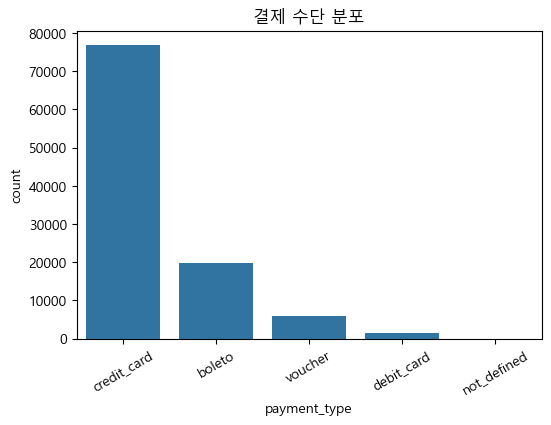


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


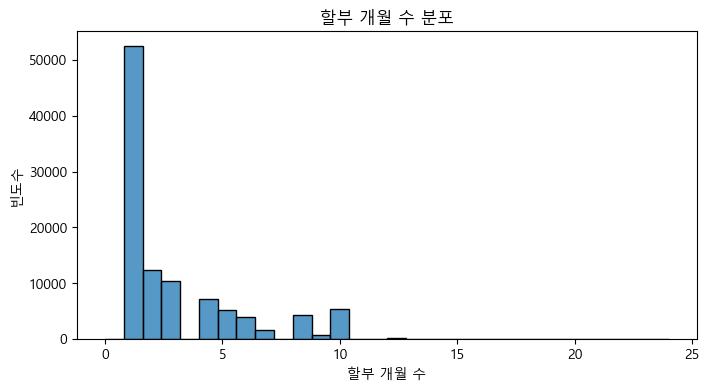


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


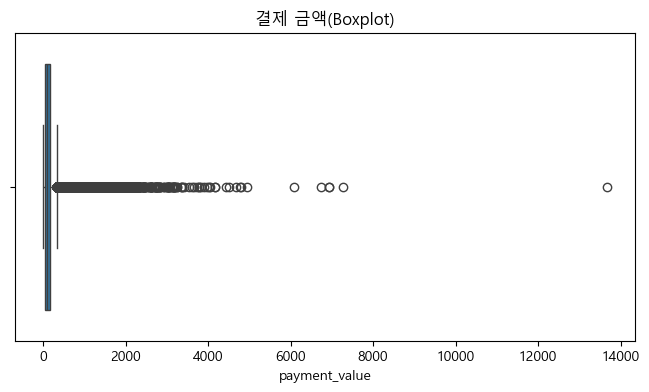

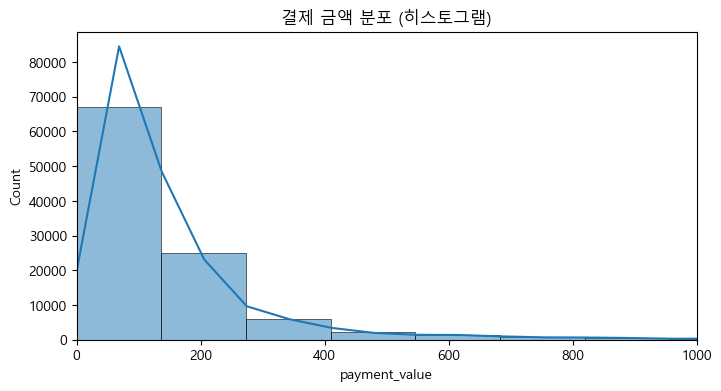


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

[결제 금액 이상치 개수] 7981 / 103886 (7.68%)


' 이상치 간주\npayment_type: 0, 음수, not_defined 제거\npayment_installments (할부 개월 수): 0(일시불)/ 음수, 24개월 초과 제거\npayment_value: 0(일시불), / 음수, Q1, Q3 기반 IQR로 극단치 검출 -> Winsorization (상한 절단)\n\n평균(Mean) = 154.1 → 극단값(고액 결제)의 영향으로 평균이 중앙값보다 큼\n최댓값 = 13,664.08 → 단 1건 정도의 초고액 결제 (전체 분포와 매우 동떨어짐)\nIQR 이상치 비율 ≈ 7.7% (7,981건) → 전체 결제의 약 8%가 극단값\n'

In [14]:
# df_order_payments: 결측X, 이상치 탐지

# 1. payment_type 분포 확인
plt.figure(figsize=(6,4))
sns.countplot(data=o_df_order_payments, x='payment_type', order=o_df_order_payments['payment_type'].value_counts().index)
plt.title("결제 수단 분포")
plt.xticks(rotation=30)
plt.show()

print("\n[결제 수단 비율]")
print(o_df_order_payments['payment_type'].value_counts(normalize=True).round(3))

# 2. 할부 개월 수 분포
plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_installments'], bins=30, kde=False)
plt.title("할부 개월 수 분포")
plt.xlabel("할부 개월 수")
plt.ylabel("빈도수")
plt.show()

print("\n[할부 개월 수 통계]")
print(o_df_order_payments['payment_installments'].describe())

# 3. 결제 금액 분포 (payment_value)
plt.figure(figsize=(8,4))
sns.boxplot(x=o_df_order_payments['payment_value'])
plt.title("결제 금액(Boxplot)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_value'], bins=100, kde=True)
plt.title("결제 금액 분포 (히스토그램)")
plt.xlim(0, 1000)  # 고액 결제는 따로 확인하기 위해 일단 1000 이하만 시각화
plt.show()

print("\n[결제 금액 통계]")
print(o_df_order_payments['payment_value'].describe())

# 4. 이상치 건수 확인 (IQR 방식)
Q1 = o_df_order_payments['payment_value'].quantile(0.25)
Q3 = o_df_order_payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (o_df_order_payments['payment_value'] < Q1 - 1.5*IQR) | (o_df_order_payments['payment_value'] > Q3 + 1.5*IQR)

print(f"\n[결제 금액 이상치 개수] {outlier_mask.sum()} / {len(o_df_order_payments)} ({outlier_mask.mean()*100:.2f}%)")

''' 이상치 간주
payment_type: 0, 음수, not_defined 제거
payment_installments (할부 개월 수): 0(일시불)/ 음수, 24개월 초과 제거
payment_value: 0(일시불), / 음수, Q1, Q3 기반 IQR로 극단치 검출 -> Winsorization (상한 절단)

평균(Mean) = 154.1 → 극단값(고액 결제)의 영향으로 평균이 중앙값보다 큼
최댓값 = 13,664.08 → 단 1건 정도의 초고액 결제 (전체 분포와 매우 동떨어짐)
IQR 이상치 비율 ≈ 7.7% (7,981건) → 전체 결제의 약 8%가 극단값
'''


In [15]:
df_order_payments = o_df_order_payments
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [16]:
'''
payments 이상치 라벨링 처리 -> 라벨링 df 생성: df_label_payment
installments = 0 → "일시불" 카테고리로 변환.
payment_value = 0 → "0원 결제" (ex. 쿠폰, 무료배송, 취소된 거래 등)으로 별도 라벨링.
'''
# 결제데이터 복사
df_lavel_payments = df_order_payments.copy()

# 일시불 라벨링
df_lavel_payments['installment_label'] = df_lavel_payments['payment_installments'].apply(
    lambda x: '일시불' if x == 0 else '할부'
)

# 결제금액 라벨링
df_lavel_payments['payment_label'] = df_lavel_payments['payment_value'].apply(
    lambda x: '0원결제' if x == 0 else '유료결제'
)

# 분포 확인
print(df_lavel_payments['installment_label'].value_counts())
print(df_lavel_payments['payment_label'].value_counts())

# 이상치로 보이는 데이터 일부 확인
print(df_lavel_payments[df_lavel_payments['payment_value'] == 0].head(10))

installment_label
할부     103884
일시불         2
Name: count, dtype: int64
payment_label
유료결제    103877
0원결제         9
Name: count, dtype: int64
                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value installment_label payment_label  
19922    

In [17]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


# MERGE
join_order_c = df_order_clean + df_customers + df_payments + df_order_items

In [18]:
'''
MERGE
customer 데이터 탐색: 이상치 처리 안함, 데이터 손실 최소화
customer states 컬럼: SP(상파울루 주), RJ (리우데자네이루 주)
'''
# df_order.info() #77694, 컬럼 12개
# df_customers.info() #99441 컬럼 5개

# 1. 주문 + 고객 정보 데이터 조인 (order_id 기준)
join_order_c= df_order_clean.merge(
    df_customers,
    on='customer_id',
    how='left'   # 주문은 반드시 유지, 고객 정보가 없으면 NaN
)

print(f"Merge 후 레코드 수: {len(join_order_c)}")
print(f"원본 df_order 레코드 수: {len(df_order)}")
print("고유 order_id 개수:", join_order_c['order_id'].nunique())
print("전체 order_id 대비 중복 비율:", 1 - join_order_c['order_id'].nunique() / len(join_order_c))

print("customer_city 결측치 개수:", join_order_c['customer_city'].isnull().sum())
print("customer_city 결측치 비율:", join_order_c['customer_city'].isnull().mean())

print(join_order_c.dtypes)

join_order_c['purchase_to_approved'].head()
print(join_order_c.isnull().sum())

Merge 후 레코드 수: 95088
원본 df_order 레코드 수: 96461
고유 order_id 개수: 95088
전체 order_id 대비 중복 비율: 0.0
customer_city 결측치 개수: 0
customer_city 결측치 비율: 0.0
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
purchase_to_approved                    float64
approved_to_carrier                     float64
carrier_to_customer                     float64
purchase_to_customer                    float64
is_outlier                                 bool
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
dtype: object
order_id                  

In [19]:
# df_join_order_cp

# 3. 1번 df + df_order_payments_sum 병합
df_join_order_cp= join_order_c.merge(
    df_order_payments,
    on='order_id',
    how='left'
)

# df_join_order_cp.info()
# print(f"Merge 후 레코드 수: {len(df_join_order_cp)}")
# print(f"원본 df_order 레코드 수: {len(df_join_order_cp)}")
# print(df_join_order_cp.isnull().sum())

# 'payment_type' 컬럼에 결측치가 있는 행만 필터링
nan_rows = df_join_order_cp[df_join_order_cp['payment_type'].isnull()]

print("=== 결측치가 있는 행 ===")
print(nan_rows)

# 결측치 개수 다시 확인
print("\n=== 결측치 개수 ===")
print(nan_rows.isnull().sum())

# 'payment_type' 컬럼에 결측치가 있는 행 제거
df_join_order_cp_cleaned = df_join_order_cp.dropna(subset=['payment_type'])

# 삭제 후 데이터프레임의 행 수 확인
print(f"결측치 제거 전 행 수: {len(df_join_order_cp):,}")
print(f"결측치 제거 후 행 수: {len(df_join_order_cp_cleaned):,}")

# 결측치가 제거되었는지 다시 확인
print("\n=== 결측치 제거 후 확인 ===")
print(df_join_order_cp_cleaned.isnull().sum())

=== 결측치가 있는 행 ===
                               order_id                       customer_id  \
30708  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   

      order_status order_purchase_timestamp   order_approved_at  \
30708    delivered      2016-09-15 12:16:38 2016-09-15 12:16:38   

      order_delivered_carrier_date order_delivered_customer_date  \
30708          2016-11-07 17:11:53           2016-11-09 07:47:38   

      order_estimated_delivery_date  purchase_to_approved  \
30708                    2016-10-04                   0.0   

       approved_to_carrier  ...  purchase_to_customer  is_outlier  \
30708            53.205035  ...             54.813194       False   

                     customer_unique_id customer_zip_code_prefix  \
30708  830d5b7aaa3b6f1e9ad63703bec97d23                    14600   

              customer_city customer_state payment_sequential  payment_type  \
30708  sao joaquim da barra             SP                NaN           NaN  

In [20]:
# MERGE 3단계: 2번 결과에 아이템 정보 병합
df_join_ocpi = df_join_order_cp.merge(
    df_order_items, 
    on='order_id', 
    how='left'
)

df_join_ocpi.info()
print(f"Merge 후 레코드 수: {len(df_join_ocpi)}")
print(df_join_ocpi.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113371 entries, 0 to 113370
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113371 non-null  object        
 1   customer_id                    113371 non-null  object        
 2   order_status                   113371 non-null  object        
 3   order_purchase_timestamp       113371 non-null  datetime64[ns]
 4   order_approved_at              113371 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113371 non-null  datetime64[ns]
 6   order_delivered_customer_date  113371 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113371 non-null  datetime64[ns]
 8   purchase_to_approved           113371 non-null  float64       
 9   approved_to_carrier            113371 non-null  float64       
 10  carrier_to_customer            113371 non-null  float64       
 11  

In [21]:
'''
과제 1: 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고,
고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시
'''
# ===============================
# 1. RFM 분석용 데이터 준비
# ===============================
# 분석 기준일 (데이터에서 가장 마지막 주문일 + 1일)
analysis_date = df_join_order_cp['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 고객별 RFM 집계
rfm = df_join_order_cp.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                                # Frequency (고객별 주문 횟수)
    'payment_value': 'sum'                                               # Monetary (총 결제 금액)
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# ===============================
# 2. RFM 점수화 (1~5등급)
# ===============================
# Recency: 최근일수 낮을수록 좋은 고객 → 낮으면 높은 점수
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency, Monetary: 값이 높을수록 좋은 고객 → 높으면 높은 점수
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# RFM 조합 점수
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# ===============================
# 3. 고객 세그먼트 분류 (예시)
# ===============================
def segment_customer(row):
    if row['R_score'] in ['4','5'] and row['F_score'] in ['4','5']:
        return '우수 고객 (VIP)'
    elif row['R_score'] in ['3','4','5'] and row['F_score'] in ['1','2']:
        return '잠재 충성 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] in ['4','5']:
        return '이탈 위험 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] in ['1','2']:
        return '이탈 고객'
    else:
        return '일반 고객'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# ===============================
# 4. 지역별 RFM 분석 확장
# ===============================

customer_region = df_join_order_cp[['customer_id', 'customer_city']].drop_duplicates(subset=['customer_id'])

rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

# 지역별 평균 RFM 값
region_summary = rfm_region.groupby('customer_city')[['Recency','Frequency','Monetary']].mean().round(1)

print("=== 지역별 평균 RFM ===")
print(region_summary.head())

# 1. customer_state 컬럼을 포함하여 조인
customer_region = df_join_order_cp[['customer_id', 'customer_city', 'customer_state']].drop_duplicates(subset=['customer_id'])

# 2. RFM 데이터에 지역 정보 병합
rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

# 3. 주(state)별 평균 RFM 값
state_summary = rfm_region.groupby('customer_state')[['Recency','Frequency','Monetary']].mean().round(1)
print("=== 주(State)별 평균 RFM ===")
print(state_summary.head())

# 1. customer_state 컬럼을 포함하여 조인
customer_region = df_join_order_cp[['customer_id', 'customer_city', 'customer_state']].drop_duplicates(subset=['customer_id'])

# 2. RFM 데이터에 지역 정보 병합
rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

# 3. 주(state)별 평균 RFM 값
state_summary = rfm_region.groupby('customer_state')[['Recency','Frequency','Monetary']].mean().round(1)
print("=== 주(State)별 평균 RFM ===")
print(state_summary.head())

# 4. 도시(city)별 평균 RFM 값
city_summary = rfm_region.groupby('customer_city')[['Recency','Frequency','Monetary']].mean().round(1)
print("\n=== 도시(City)별 평균 RFM ===")
print(city_summary.head())

=== 지역별 평균 RFM ===
                     Recency  Frequency  Monetary
customer_city                                    
abadia dos dourados    270.5        1.0     177.6
abadiania              214.0        1.0    1025.5
abaete                 245.9        1.0     163.0
abaetetuba             206.1        1.0     424.8
abaiara                194.5        1.0     166.1
=== 주(State)별 평균 RFM ===
                Recency  Frequency  Monetary
customer_state                              
AC                322.6        1.0     247.4
AL                268.9        1.0     238.0
AM                270.6        1.0     190.9
AP                246.3        1.0     240.9
BA                246.2        1.0     182.1
=== 주(State)별 평균 RFM ===
                Recency  Frequency  Monetary
customer_state                              
AC                322.6        1.0     247.4
AL                268.9        1.0     238.0
AM                270.6        1.0     190.9
AP                246.3        1.0     24

In [22]:
'''
지역별(state, city별) 고객을 세분화하여 세그먼트별 특징
고객등급 별 구매금액
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']
구매 기간 및 주기 계산 (추가하기)
'''

"\n지역별(state, city별) 고객을 세분화하여 세그먼트별 특징\n고객등급 별 구매금액\ncustomer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']\ncustomer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']\n구매 기간 및 주기 계산 (추가하기)\n"